In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mtick
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split
from tabulate import tabulate

### Init Dataset

In [3]:
df = pd.read_csv("KC_housing_data.csv")
plt.style.use("seaborn-v0_8")
sns.set_palette("muted")

### Data Cleaning and Preparation

In [4]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")

df = df.drop_duplicates()

df = df[df["price"] > 50000]

zip_city = df.groupby(["city", "statezip"])["price"].mean().reset_index().sort_values("price", ascending=False)
zip_city.head(10)
top_cities = df.groupby("city")["price"].mean().sort_values(ascending=False).head(10)
top_zips = df.groupby("statezip")["price"].mean().sort_values(ascending=False).head(10)
# top 10 cities
top_cities_list = top_cities.index.tolist()
# top 10 zips
top_zips_list = top_zips.index.tolist()
# see which top zips belong to which top cities
overlap = zip_city[zip_city["statezip"].isin(top_zips_list) & zip_city["city"].isin(top_cities_list)]
print(df.columns)
print(df.isna().sum())

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country'],
      dtype='object')
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64


### Summary Statistics

In [5]:
avg_price = df["price"].mean()
min_price = df["price"].min()
max_price = df["price"].max()

print(f"AVG price: {avg_price:,.0f}")
print(f"Min price: {min_price:,.0f}")
print(f"Max price: {max_price:,.0f}")

AVG price: 558,027
Min price: 80,000
Max price: 26,590,000


### Price Distribution

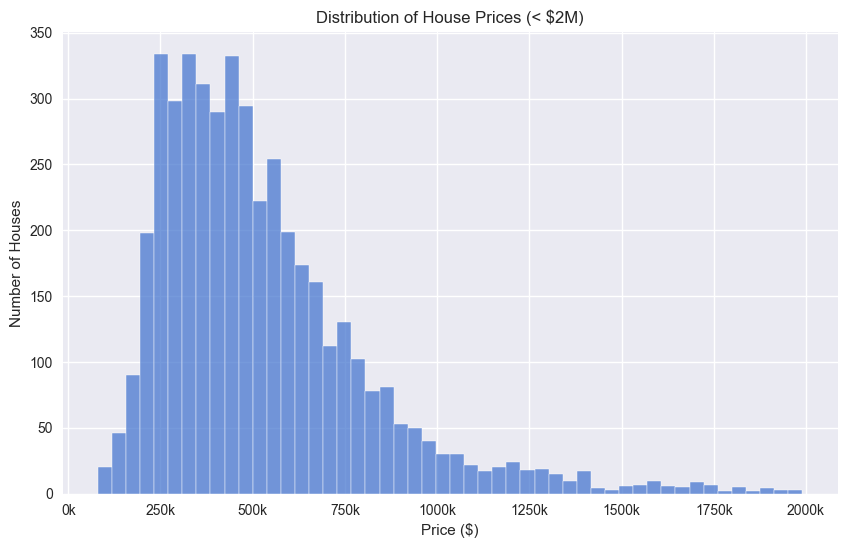

In [6]:
plt.figure(figsize=(10,6))
ax = sns.histplot(df[df["price"] < 2000000]["price"], bins=50, kde=False)
plt.title("Distribution of House Prices (< $2M)")
plt.xlabel("Price ($)")
plt.ylabel("Number of Houses")
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1000)}k'))
plt.show()

### Top 10 Cities by Average Price (Waterfront Homes)

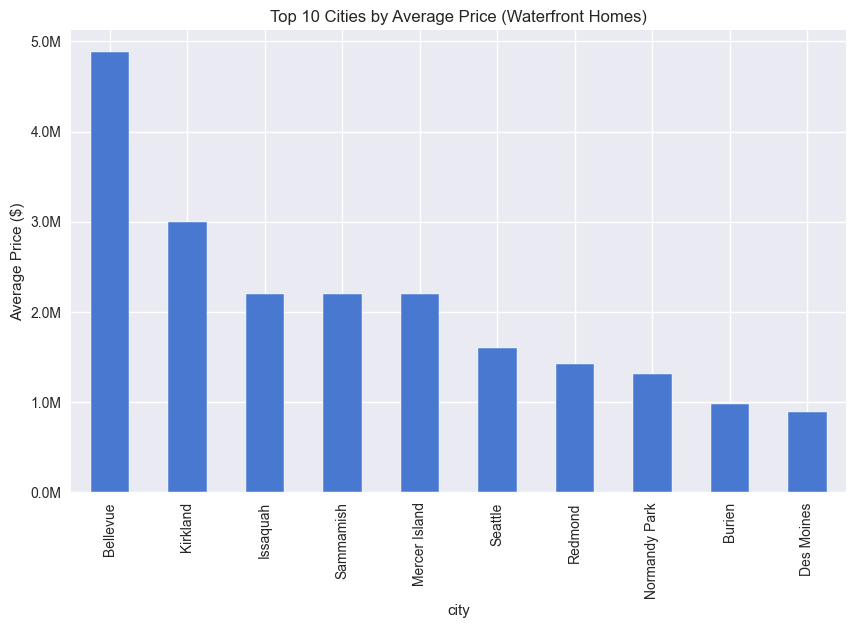

In [7]:
waterfront = df[df["waterfront"] == 1]
avg_price_waterfront = waterfront.groupby("city")["price"].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
ax = avg_price_waterfront.head(10).plot(kind="bar")
plt.title("Top 10 Cities by Average Price (Waterfront Homes)")
plt.ylabel("Average Price ($)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{y/1e6:.1f}M'))
plt.show()

## Target is Bellevue

In [8]:
bellevue_df = df[df["city"] == "Bellevue"].copy()
bellevue_df["days"] = (bellevue_df["date"] - bellevue_df["date"].min()).dt.days
filtered_df = bellevue_df[
    (bellevue_df["sqft_living"] <= 6000) &
    (bellevue_df["price"] <= 3000000)
]

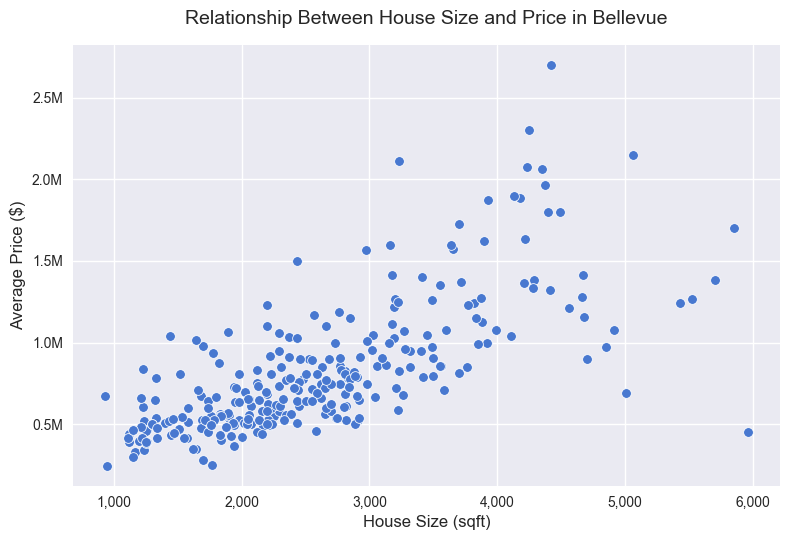

In [9]:
# Defining a features and target also ploting
features = ["sqft_living", "bedrooms", "bathrooms", "floors", "waterfront", "condition", "yr_renovated", "view"]
target = "price"

X = filtered_df[features]
y = filtered_df[target]

ax = sns.scatterplot(
    data=filtered_df,
    x="sqft_living",
    y="price",
)

# Plot the relationship between house size and price
plt.title("Relationship Between House Size and Price in Bellevue", fontsize=14, pad=15)
plt.xlabel("House Size (sqft)", fontsize=12)
plt.ylabel("Average Price ($)", fontsize=12)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{y/1e6:.1f}M'))
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.tight_layout()
plt.show()

In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [12]:
# Evaluation
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

mean_price = y_test.mean()
percentage_error = (rmse / mean_price) * 100

print("Model Evaluation Metrics:")
print(f"  Mean Squared Error (MSE): ${mse/1e6:,.2f}M")
print(f"  Root Mean Squared Error (RMSE): ${rmse/1e3:,.2f}K")
print(f"  Average Relative Error: {percentage_error:.2f}%")


Model Evaluation Metrics:
  Mean Squared Error (MSE): $96,985.71M
  Root Mean Squared Error (RMSE): $311.43K
  Average Relative Error: 35.25%


### Plot Predicted vs Actual House Prices

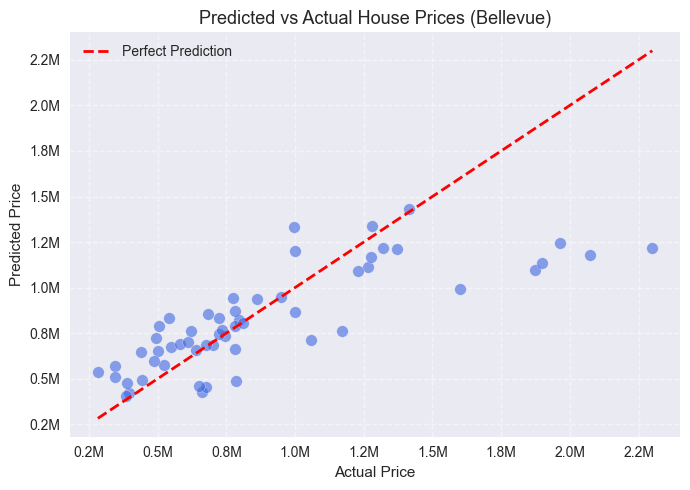

In [13]:
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.6, color='royalblue', edgecolor='white', s=70)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--',
    linewidth=2,
    label="Perfect Prediction"
)

plt.title("Predicted vs Actual House Prices (Bellevue)", fontsize=13)
plt.xlabel("Actual Price", fontsize=11)
plt.ylabel("Predicted Price", fontsize=11)
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{y/1e6:.1f}M'))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Classifying Expensive Houses in Bellevue

In [14]:
# Computing a median price
filtered_df = filtered_df.copy()
median_price = filtered_df["price"].median()
filtered_df["is_expensive"] = (filtered_df["price"] > median_price).astype(int)

print(f"Median price in Bellevue: {median_price:,.0f}")
counts = filtered_df["is_expensive"].value_counts()
print("-- Class distribution --")
print(f"Not Expensive: {counts[0]} houses -> label 0")
print(f"Expensive: {counts[1]} houses -> label 1")

Median price in Bellevue: 724,000
-- Class distribution --
Not Expensive: 139 houses -> label 0
Expensive: 139 houses -> label 1


In [15]:
# Define a features and then spliting the data
features = ["sqft_living", "bedrooms", "bathrooms", "floors", "waterfront", "condition", "yr_renovated", "view"]
X = filtered_df[features]
y = filtered_df["is_expensive"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [16]:
# Train the model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

In [17]:
# Evaluate and check accuracy
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
print(f"Classification Accuracy: {acc:.2%}")
print(f"ROC AUC Score: {auc:.2%}")

Classification Accuracy: 82.14%
ROC AUC Score: 91.61%


#### Confusion Matrix

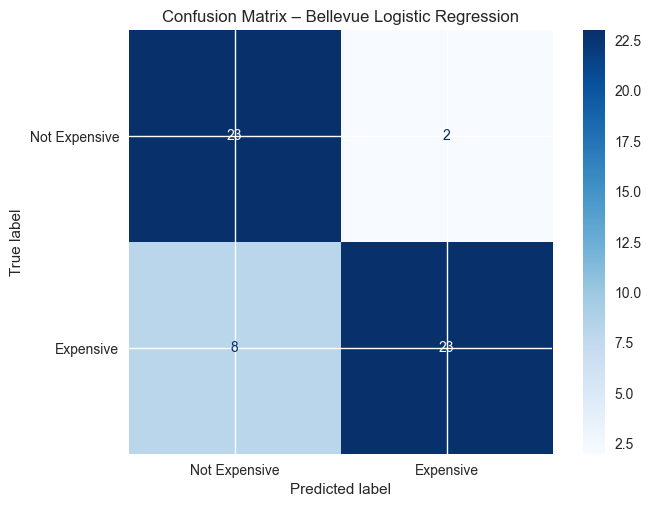

In [18]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Expensive", "Expensive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Bellevue Logistic Regression")
plt.show()

#### Receiver Operating Characteristic Curve

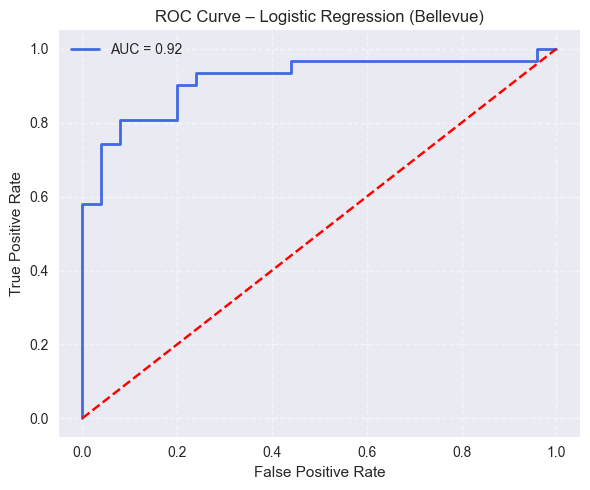

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='royalblue', linewidth=2, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression (Bellevue)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()